## Imports

In [ ]:
import nltk
from pathlib import Path
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

### Figure 2a

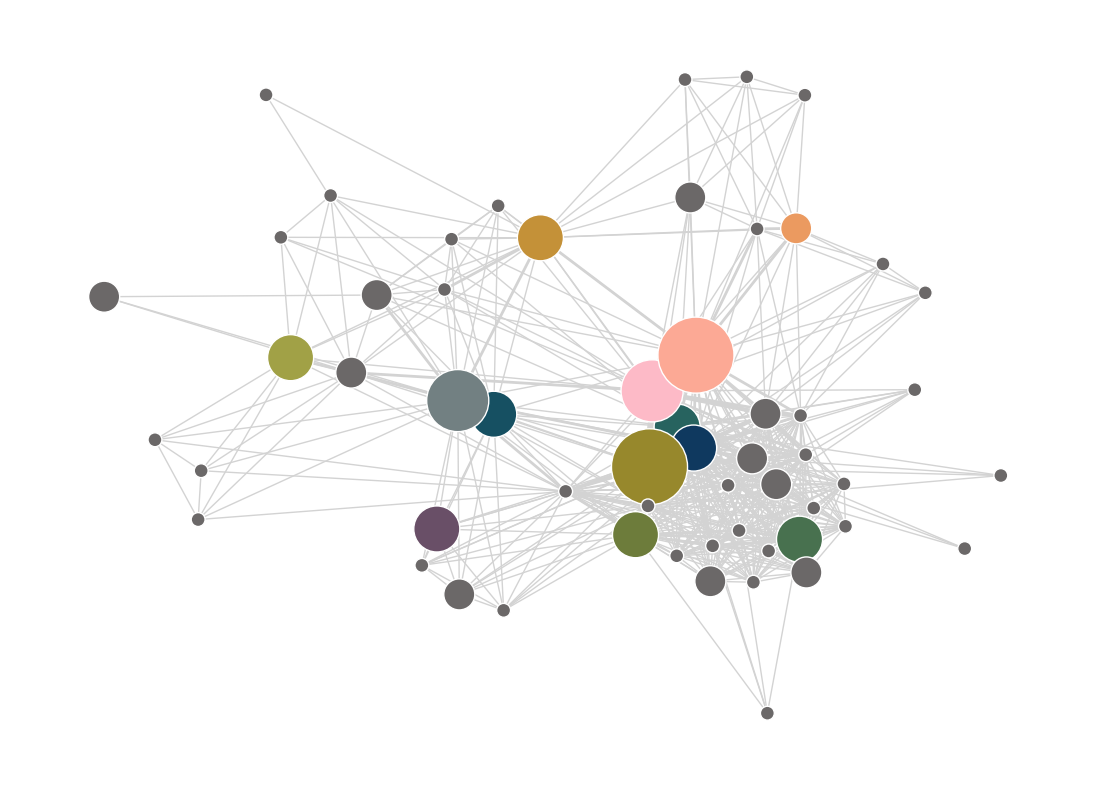

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# Define palette
ORG_PALETTE = {
    '#48714f': 'EA',
    '#6d7c3b': 'DEFRA',
    '#97882c': 'HMRC',
    '#c49138': 'FCDO',
    '#0f395f': 'CO',
    '#27635f': 'BEIS',
    '#eb9a60': 'ESFA',
    '#fca995': 'DfE',
    '#165062': 'DVSA',
    '#fdbac7': 'DWP',
    '#a1a146': 'MoJ',
    '#728082': 'HO',
    '#694f67': 'DVLA',
}

def get_node_size(service_count):
    if service_count <= 4:
        return 100  # Very node
    elif 5 <= service_count <= 10:
        return 500  # Medium-small node
    elif 11 <= service_count <= 19:
        return 1100  # Medium node
    elif 20 <= service_count <= 29:
        return 2000  # Medium-large node
    elif 30 <= service_count <= 31:
        return 3000  # Large node

def plot_organisation_network(save=False):
    """
    Load and plot organisations network.
    """
    
    # Assuming services_df is your DataFrame
    services_df = pd.read_pickle(Path('../data/processed/dataframes/descriptive-df-w-api-data.pkl'))

    # Abbreviate organisation names
    mapping = {
        'Department for Business, Energy & Industrial Strategy': 'BEIS', 
        'Department for Environment, Food & Rural Affairs': 'DEFRA',
        'Department for Education' : 'DfE',
        'Department for Work and Pensions': 'DWP',
        'Driver and Vehicle Licensing Agency': 'DVLA',
        'Driver and Vehicle Standards Agency': 'DVSA',
        'HM Revenue and Customs': 'HMRC', 
        'Home Office': 'HO',
        'Ministry of Justice': 'MoJ',
        'Environment Agency': 'EA',
        'Foreign, Commonwealth & Development Office': 'FCDO',
        'Education and Skills Funding Agency': 'ESFA',
        'Cabinet Office': 'CO'
    }
    
    services_df.replace(mapping, inplace=True) 
    
    # Task 1: Create a NetworkX graph
    G = nx.Graph()

    # Add nodes for organizations
    org_service_count = services_df.groupby('organisation')['service'].nunique().reset_index()
    org_service_count.columns = ['organisation', 'service_count']

    # Create a list to store colors for nodes
    node_colors = []

    # Task 1.1: Assign unique colors to nodes with 10 or more services
    for index, row in org_service_count.iterrows():
        if row['organisation'] in ORG_PALETTE.values():
            G.add_node(row['organisation'], size=row['service_count'], color=row['service_count'])
            node_colors.append(list(ORG_PALETTE.keys())[list(ORG_PALETTE.values()).index(row['organisation'])])  # Use the color from ORG_PALETTE
        else:
            G.add_node(row['organisation'], size=row['service_count'], color=0)  # 0 represents 'Other' nodes
            node_colors.append('#6b6868')  # Color nodes with less than 10 services as #6b6868

    # Task 2: Add edges between organizations based on shared topics, edge weight based on the number of shared topics
    # Also keep account of which service topics are most commonly shared
    num_shares = {}
    seen_orgs = [] #keep track so we don't do edges twice
    edges = []
    for org1 in org_service_count['organisation']:
        for org2 in org_service_count['organisation']:
            if org1 != org2 and (org1, org2) not in seen_orgs:
                topics1 = set(services_df[services_df['organisation'] == org1]['topic'])
                topics2 = set(services_df[services_df['organisation'] == org2]['topic'])
                shared_topics = topics1.intersection(topics2)
                if shared_topics:
                    G.add_edge(org1, org2, weight=len(shared_topics))
                    edges.append((org1, org2, len(shared_topics)))
                    
                    #add num share statistics
                    for top in shared_topics:
                        if not top in num_shares:
                            num_shares[top] = 0
                        num_shares[top] += 1

                    #add the reverse of this edge to make sure we don't do it again 
                    seen_orgs.append((org2, org1))

    # Get node sizes using the get_node_size function
    node_sizes = [get_node_size(data['size']) for _, data in G.nodes(data=True)]

    # Get edge weights
    edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

    # Create a force-directed layout
    pos = nx.spring_layout(G)
    
    # Draw the network diagram
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, linewidths=1, edgecolors='white')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='lightgrey')

    # No need to draw node labels separately

    # Task 3: Create a custom legend for nodes with 10 or more services and 'Other' nodes
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12, label=f'{org} (n={count})')
                       for org, count, color in zip(org_service_count['organisation'], org_service_count['service_count'], node_colors)
                       if count >= 10]  # Filter nodes with 10 or more services

    # Add a label for 'Other' nodes
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#6b6868', markersize=12, label='Other'))

    # Create legend in the lower left
    # plt.legend(handles=legend_elements, borderaxespad=0., loc='upper left', frameon=False, fontsize=16, ncol=1, bbox_to_anchor=(1,0))

    plt.axis('off')

    # Save figure
    if save == True:
        plt.savefig(Path("../reports/figures/main-figures/fig2a.pdf"), dpi=600, bbox_inches='tight')
    else:
        plt.show()
    
plot_organisation_network(save=True);

**Interpretation**
- There is a central cluster of organisations that offer the most services; this is perhaps where efforts to adopt automation should be concentrated

## Figure 2b

In [88]:
import plotly.express as px
import pandas as pd
from pathlib import Path

def polar_chart_with_legend(df, legend=False, save=False):
    # Define custom color palette
    cusotm_colors = [
        '#006600', '#003300',
        '#003366', '#666633', '#660066', '#336666', '#660000',
        '#045275', '#089099', '#7CCBA2', '#FCDE9C', '#F0746E',
        '#DC3977', '#7C1D6F', '#339900', '#993300', '#FF6600',
    ]
    # Sort the DataFrame based on the desired column
    sorted_df = df.sort_values(by='organisation', ascending=True)

    fig = px.bar_polar(sorted_df, r='service', theta='organisation', 
                       color='topic',
                       color_discrete_sequence=cusotm_colors, start_angle=90)

    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=False,
                # range=[0, 7000],  # Adjust range if needed
                dtick=20,  # Set the tick frequency for better readability
                showline=False,  # Hide radial axis line
                showticklabels=False
            ),
            angularaxis=dict(
                rotation=90,  # Rotate the bar labels
                direction="clockwise",  # Ensure labels are parallel to the top of the bar
                showticklabels=False,  # Hide the tick labels
                showline=False  # Hide angular axis line
            ),
            bargap=0.1,  # Adjust the gap between bars for better visualization
            bgcolor='white',  # Set the background color of the plot to white
            hole=0.075,  # Make the central white circle 3 times as big
        ),
        width=1500,  # Make the plot twice as big
        height=1500,  # Make the plot twice as big
    )

    # Adjust the size of the marks (bars)
    fig.update_traces(r=([5] * len(sorted_df)))

    if legend:
        fig.update_layout(
            legend=dict(
                x=2,  # Adjust the x position of the legend (0 is left, 1 is right)
                y=.5,  # Adjust the y position of the legend (0 is bottom, 1 is top)
                traceorder='normal',  # Set the order in which legend items are displayed
                font=dict(
                    family="Helvetica",  # Set the font family
                    size=14,  # Set the font size
                    color="black"  # Set the font color
                ),
                bgcolor="white",  # Set the background color of the legend
                bordercolor="white",  # Set the border color of the legend
                borderwidth=1  # Set the border width of the legend
            )
        )
    else:
        fig.update_traces(showlegend=False)

    if save:
        fig.write_image("../reports/figures/main-figures/fig2b.pdf", format="pdf", width=1500, height=1500, scale=2)
    else:
        fig.show()

# Example usage:
data_path = Path('../data/processed/dataframes/descriptive-df-w-api-data.pkl')
# Load DataFrame
filtered_df = pd.read_pickle(data_path)
polar_chart_with_legend(filtered_df, legend=False, save=True)

In [15]:
for i in list(filtered_df.organisation.sort_values().unique()):
    print(i+',')

Animal and Plant Health Agency,
Cabinet Office,
Care Quality Commissions,
Civil Aviation Authority,
Civil Service Fast Stream,
Companies House,
Crown Commercial Service,
Department for Business, Energy & Industrial Strategy,
Department for Digital, Culture, Media and Sport,
Department for Education,
Department for Environment, Food & Rural Affairs,
Department for International Trade,
Department for Levelling Up, Housing & Communities,
Department for Transport,
Department for Work and Pensions,
Department of Health and Social Care,
Disclosure and Barring Service,
Driver and Vehicle Licensing Agency,
Driver and Vehicle Standards Agency,
Education and Skills Funding Agency,
Environment Agency,
Foreign, Commonwealth & Development Office,
General Register Office,
Government Digital Service,
Government Equalities Office,
HM Courts & Tribunals Service,
HM Passport Office,
HM Revenue and Customs,
Highways England,
Home Office,
Innovate UK,
Insolvency Service,
Intellectual Property Office,
Land

### Figure 2c

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

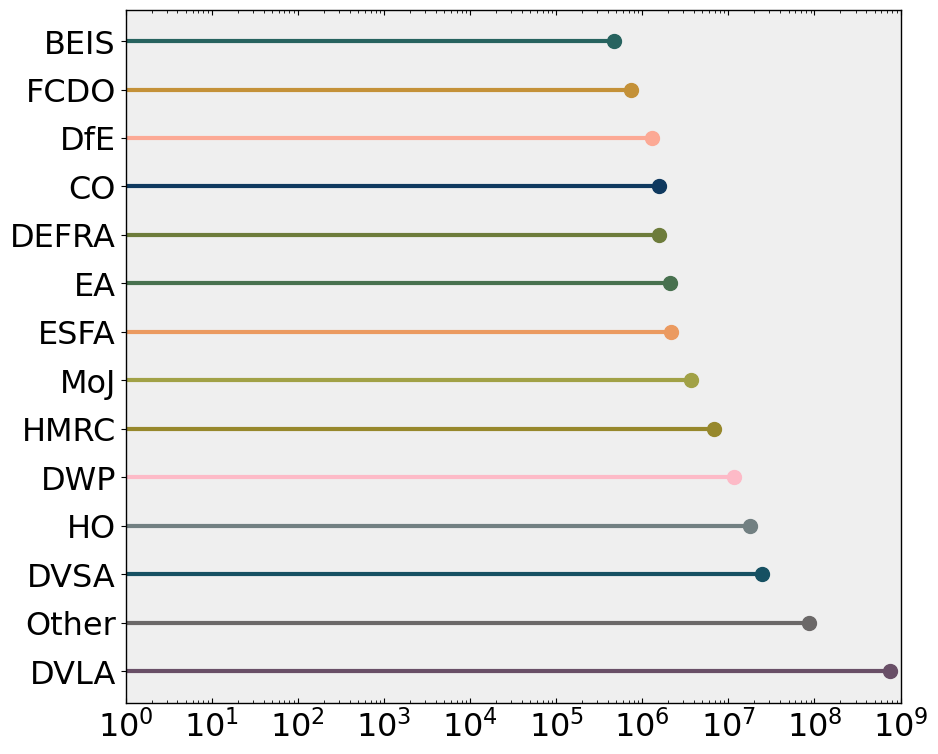

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path

def plot_transaction_volumes_per_org(save=False):
    """
    Load and plot processed transaction volumes data per organisation.
    """
    
    # Load and preprocess the data
    data_path = Path('../data/processed/202308-services-list-w-transaction-vol-processed.xlsx')
    df = pd.read_excel(data_path)
    df.sort_values('transaction_value', ascending=False, inplace=True)
    
    # Count the number of services per organization
    org_service_count = df['organisation'].value_counts()
    
    # Create a mask to identify organizations with less than 10 services
    mask = org_service_count < 10
    
    # Abbreviate organisation names
    mapping = {
        'Department for Business, Energy & Industrial Strategy': 'BEIS', 
        'Department for Environment, Food & Rural Affairs': 'DEFRA',
        'Department for Education' : 'DfE',
        'Department for Work and Pensions': 'DWP',
        'Driver and Vehicle Licensing Agency': 'DVLA',
        'Driver and Vehicle Standards Agency': 'DVSA',
        'HM Revenue and Customs': 'HMRC', 
        'Home Office': 'HO',
        'Ministry of Justice': 'MoJ',
        'Environment Agency': 'EA',
        'Cabinet Office': 'CO',
        'Education and Skills Funding Agency': 'ESFA',
        'Foreign, Commonwealth & Development Office': 'FCDO',
    }
    
    df.replace(mapping, inplace=True) 
    
    # Get the list of organizations with less than 10 services
    other_organisations = org_service_count[mask].index.tolist()
    
    # Replace the organizations with less than 10 services with 'Other'
    df['grouped_organisation'] = df['organisation'].apply(lambda x: 'Other' if x in other_organisations else x)
    
    # Group the DataFrame by the 'grouped_organisation' column
    grouped_df = df.groupby('grouped_organisation')['transaction_value'].sum().reset_index()
    
    grouped_df = grouped_df.sort_values(by='transaction_value', ascending=False)
    
    # Define palette
    ORG_PALETTE = {
        'EA': '#48714f',
        'DEFRA': '#6d7c3b',
        'HMRC': '#97882c',
        'FCDO': '#c49138',
        'CO': '#0f395f',
        'BEIS': '#27635f',
        'ESFA': '#eb9a60',
        'DfE': '#fca995',
        'DVSA': '#165062',
        'DWP': '#fdbac7',
        'MoJ': '#a1a146',
        'HO': '#728082',
        'DVLA': '#694f67',
        'Other': '#6b6868'
    }
    
    # Set the font to Helvetica
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    
    # Create a new figure with a white background
    fig, ax = plt.subplots(figsize=(10, 9))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#efefef')
    
    # Plot the chart
    for index, row in grouped_df.iterrows():
        plt.plot(row['transaction_value'], 
                 row['grouped_organisation'], "o",
                 color=ORG_PALETTE.get(row['grouped_organisation']),
                 markersize=10)  # Plot data points
        plt.plot([0, row['transaction_value']], 
                 [row['grouped_organisation'], 
                 row['grouped_organisation']], 
                 color=ORG_PALETTE.get(row['grouped_organisation']),
                 linewidth=3)  # Plot lines
    
    # Add title and labels
    plt.ylabel('')
    plt.xlabel('')
    
    # Format the plot
    ax.grid(False)  
    plt.xscale("log")
    plt.xlim(xmin=1, xmax=1000000000)
    plt.xticks(
        fontsize=23
    )
    
    # Set tick labels
    ax.tick_params(axis='y', labelsize=23)
    ax.tick_params(
        axis='x',
        which='both',
        direction='in',
        bottom=True,
        top=True,
        labelbottom=True,
        labeltop=False,
        pad=5  # Set padding between tick labels and ticks
    )
    
    # Modify the spines
    ax.spines['top'].set_color('black')  # Remove top spine
    ax.spines['right'].set_color('black')  # Remove right spine
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)

    # Save figure
    if save:
        plt.savefig("../reports/figures/main-figures/fig2c.pdf", dpi=600, bbox_inches='tight')
    else:
        plt.show()

# Plot
plot_transaction_volumes_per_org(save=True)

### Figure 2d

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

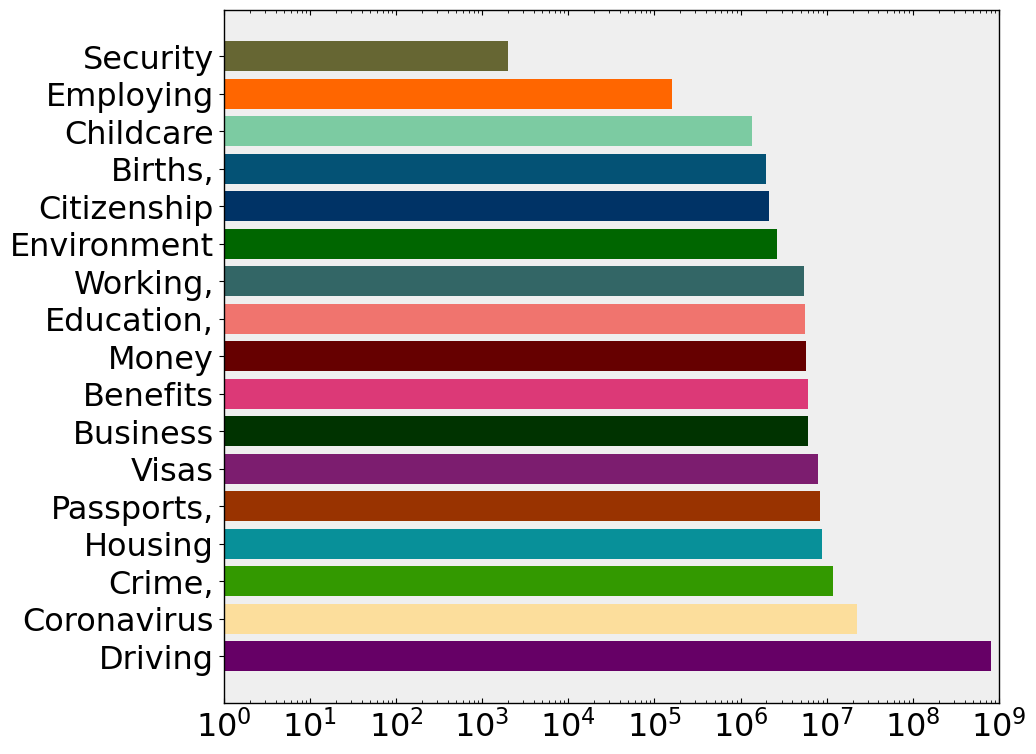

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path

def plot_transaction_volumes_per_topic(save=False):
    # Load and preprocess the data
    data_path = Path('../data/processed/202308-services-list-w-transaction-vol-processed.xlsx')
    df = pd.read_excel(data_path)
    df.sort_values('transaction_value', ascending=False, inplace=True)
    
    # Group the DataFrame by the 'grouped_organisation' column
    df = df.groupby('topic')['transaction_value'].sum().reset_index()
    
    grouped_df = df.sort_values(by='transaction_value', ascending=False)
    
    # Define palette
    topic_color_mapping = {
        'Environment and countryside': '#006600',
        'Business and self-employed': '#003300',
        'Citizenship and living in the UK': '#003366',
        'National security': '#666633',
        'Driving and transport': '#660066',
        'Working, jobs and pensions': '#336666',
        'Money and tax': '#660000',
        'Births, deaths, marriages and care': '#045275',
        'Housing and local services': '#089099',
        'Childcare and parenting': '#7CCBA2',
        'Coronavirus (COVID-19)': '#FCDE9C',
        'Education, training and skills': '#F0746E',
        'Benefits': '#DC3977',
        'Visas and immigration': '#7C1D6F',
        'Crime, justice and the law': '#339900',
        'Passports, travel and living abroad': '#993300',
        'Employing people': '#FF6600'
    }
    
    # Set the font to Helvetica
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Helvetica']
    
    # Create a new figure with a white background
    fig, ax = plt.subplots(figsize=(10, 9))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#efefef')
 
    # Plot the chart
    for index, row in grouped_df.iterrows():
        topic = row['topic']
        if topic == 'National security':
            topic = 'Security'
        else:
            topic = topic.split()[0]
        plt.barh(topic, row['transaction_value'], color=topic_color_mapping.get(row['topic']))
    
    # Add title and labels
    plt.ylabel('')
    plt.xlabel('')
    
    # Format the plot
    ax.grid(False)  
    plt.xscale("log")
    plt.xlim(xmin=1, xmax=1000000000)
    plt.xticks(
        fontsize=23
    )
    
    # Set tick labels
    ax.tick_params(axis='y', labelsize=23)
    ax.tick_params(
        axis='x',
        which='both',
        direction='in',
        bottom=True,
        top=True,
        labelbottom=True,
        labeltop=False,
        pad=5  # Set padding between tick labels and ticks
    )
    
    # Modify the spines
    ax.spines['top'].set_color('black')  # Remove top spine
    ax.spines['right'].set_color('black')  # Remove right spine
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    
    # Save figure
    if save:
        plt.savefig("../reports/figures/main-figures/fig2d.pdf", dpi=600, bbox_inches='tight')
    else:
        plt.show()

plot_transaction_volumes_per_topic(save=True)

### Figure 2e

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


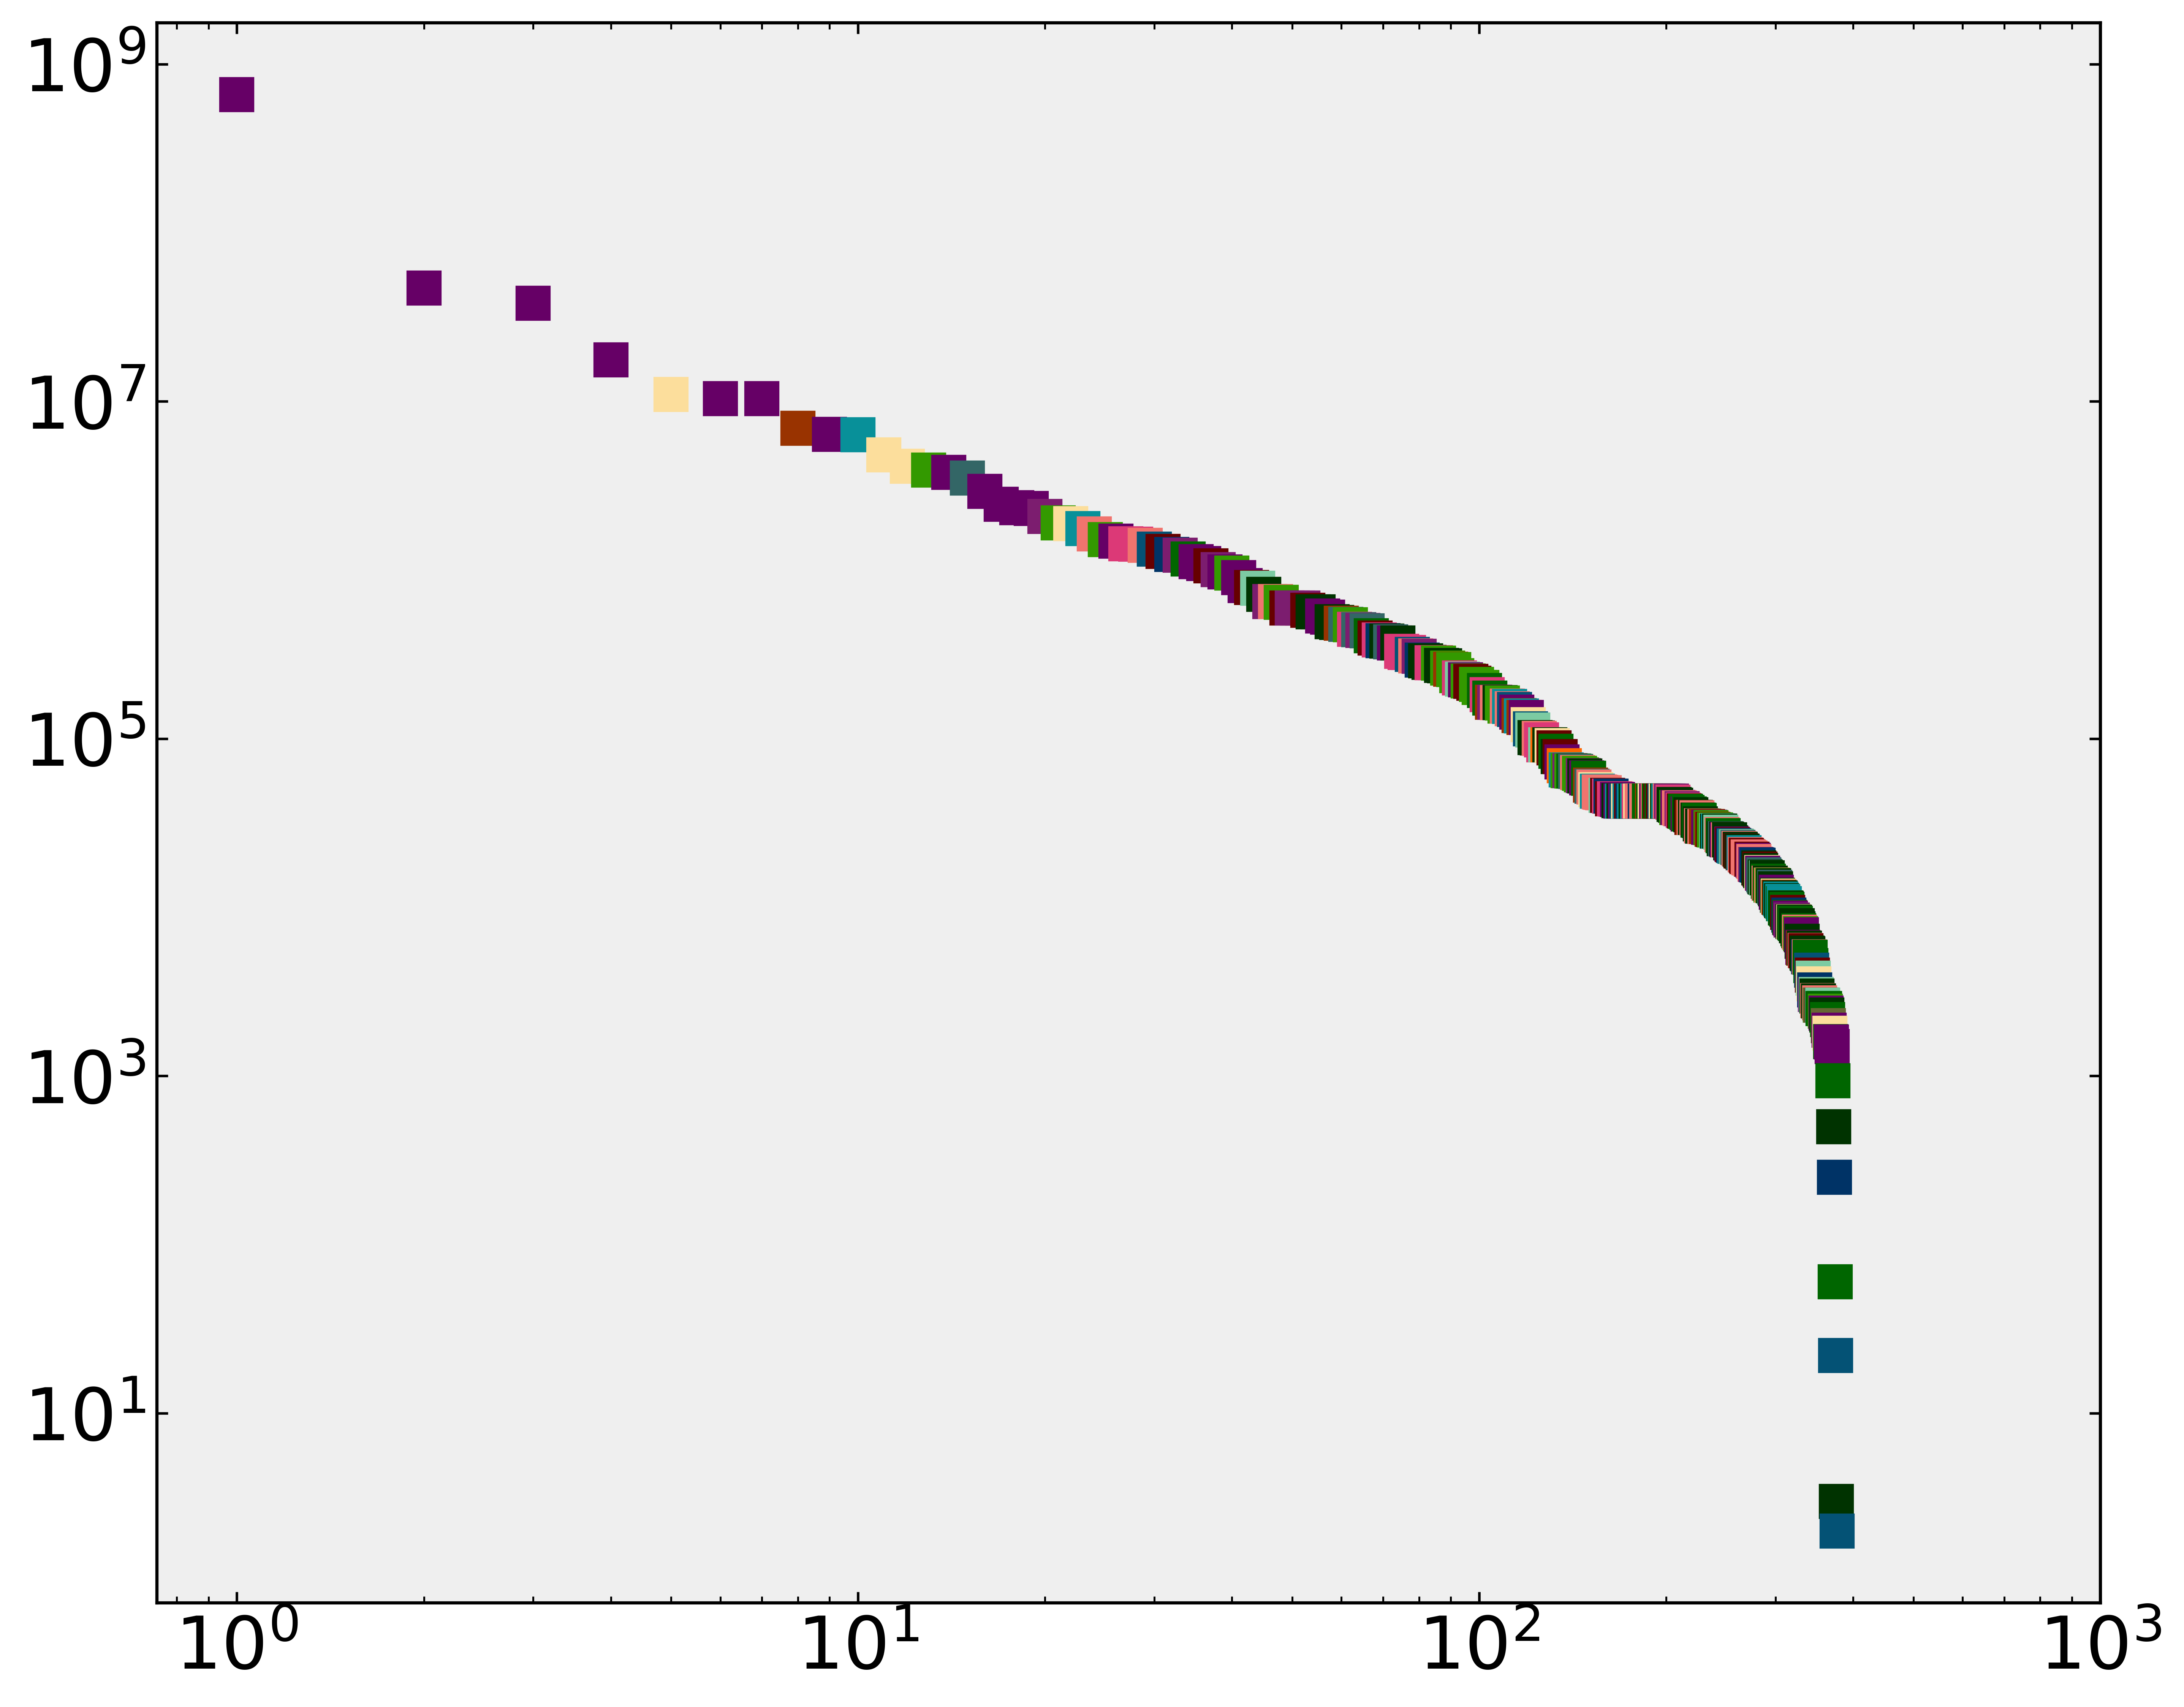

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import pyplot as plt, ticker as mticker

def plot_transaction_volumes(save=False):
    """
    Load and plot processed transaction volumes data.
    """
    # Load and preprocess the data
    data_path = Path('../data/processed/202308-services-list-w-transaction-vol-processed.xlsx')
    df = pd.read_excel(data_path)
    df.sort_values('transaction_value', ascending=False, inplace=True)

    n = len(df)
    df['rank'] = np.arange(1, n+1)
    freqs = list(df.transaction_value)
    
    # Create the figure and axis
    figure = plt.figure(figsize=(11, 9), dpi=600)
    plt.rcParams["font.family"] = "Helvetica"
    ax = plt.subplot()

    # Define custom color palette
    custom_colors = [
        '#006600', '#003300',
        '#003366', '#666633', '#660066', '#336666', '#660000',
        '#045275', '#089099', '#7CCBA2', '#FCDE9C', '#F0746E',
        '#DC3977', '#7C1D6F', '#339900', '#993300', '#FF6600',
    ]

    # Map each topic to its color using the provided dictionary
    color_dict = {
        'Environment and countryside': custom_colors[0],
        'Business and self-employed': custom_colors[1],
        'Citizenship and living in the UK': custom_colors[2],
        'National security': custom_colors[3],
        'Driving and transport': custom_colors[4],
        'Working, jobs and pensions': custom_colors[5],
        'Money and tax': custom_colors[6],
        'Births, deaths, marriages and care': custom_colors[7],
        'Housing and local services': custom_colors[8],
        'Childcare and parenting': custom_colors[9],
        'Coronavirus (COVID-19)': custom_colors[10],
        'Education, training and skills': custom_colors[11],
        'Benefits': custom_colors[12],
        'Visas and immigration': custom_colors[13],
        'Crime, justice and the law': custom_colors[14],
        'Passports, travel and living abroad': custom_colors[15],
        'Employing people': custom_colors[16]
    }

    # Plot each data point
    for index, row in df.iterrows():
        rank = row['rank']
        freq = row['transaction_value']
        topic = row['topic']

        # Plot the data point with the corresponding color
        ax.plot(rank, freq, linestyle="", marker="s", markersize=10, color=color_dict[topic])

    ax.grid(False)
    # Set the face color
    plt.gca().set_facecolor('#efefef')

    # Add major and minor ticks facing inwards
    ax.tick_params(
        axis='both',
        which='both',
        direction='in',
        top=True,
        right=True,
        bottom=True,
        left=True,
        labelsize=12
    )
    
    # Set the log scale on the y-axis
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(xmin=0,xmax=1000)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    # Modify the spines
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    # Save figure
    if save:
        plt.savefig("../reports/figures/main-figures/fig2e.pdf", bbox_inches='tight', dpi=300)
    else:
        plt.show()

# Call the function to plot the data
plot_transaction_volumes(save=True)